In [21]:
# Env Setup
!pip install tensorflow librosa numpy matplotlib
import os, random, math
from pathlib import Path
import numpy as np
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import callbacks

In [22]:
# Audio Parameters
SAMPLE_RATE = 8000
WINDOW_SIZE = 0.025
FFT_SIZE = int(SAMPLE_RATE * WINDOW_SIZE)
HOP_SIZE = int(0.010 * SAMPLE_RATE)
N_MFCC = 32
MAX_DURATION = 2.0
EXPECTED_SAMPLES = int(SAMPLE_RATE * MAX_DURATION)
FIXED_FRAMES = 80
print("Sample rate:", SAMPLE_RATE)

Sample rate: 8000


In [23]:
# Load file paths
lang = "es"
data_path = "../dataset"
data_root = Path(data_path + "/" + lang)   
if not data_root.exists():
    # Fallback if running from a different directory depth
    data_root = Path("voiceRover/dataset/" + lang)

label_names = sorted([d.name for d in data_root.iterdir() if d.is_dir()])
label_to_idx = {n:i for i,n in enumerate(label_names)}

files = []
labels = []
for label in label_names:
    for f in sorted((data_root/label).glob("*.wav")):
        files.append(str(f))
        labels.append(label_to_idx[label])

print(f"Found {len(files)} files in {label_names}")

Found 40 files in ['backward', 'forward', 'left', 'right']


In [24]:
# ---- HELPER FUNCTIONS (Augmentation + Normalization) ----

def augment_audio(y, sr):
    # 1. Add Gaussian Noise
    noise_amp = 0.005 * np.random.uniform() * np.amax(y)
    y = y + noise_amp * np.random.normal(size=y.shape[0])
    # 2. Time Shift
    shift_samples = int(sr * 0.1)
    shift_direction = np.random.choice([-1, 1])
    y = np.roll(y, shift_samples * shift_direction)
    return y

def extract_mfcc(path, augment=False):
    y, sr = librosa.load(path, sr=SAMPLE_RATE, mono=True)
    # Normalize Volume
    if y.size > 0:
        y = y / (np.max(np.abs(y)) + 1e-9)
    y, _ = librosa.effects.trim(y, top_db=20)
    
    # Augmentation
    if augment:
        y = augment_audio(y, sr)
    
    # Pad/Truncate
    if len(y) > EXPECTED_SAMPLES:
        y = y[:EXPECTED_SAMPLES]
    else:
        pad_len = EXPECTED_SAMPLES - len(y)
        if pad_len > 0:
            y = np.pad(y, (0, pad_len), mode='constant')

    # Compute MFCC
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC, n_fft=FFT_SIZE, hop_length=HOP_SIZE)
    mfcc = mfcc.T.astype(np.float32)

    # --- NORMALIZATION (Fixes 'Flat' Image) ---
    mean = np.mean(mfcc, axis=0)
    std = np.std(mfcc, axis=0)
    mfcc = (mfcc - mean) / (std + 1e-6)
    
    return mfcc

In [25]:
# ---- DATASET EXPANSION ----
expanded_files = []
expanded_labels = []
AUGMENT_FACTOR = 15 

for f, l in zip(files, labels):
    for _ in range(AUGMENT_FACTOR):
        expanded_files.append(f)
        expanded_labels.append(l)

# Shuffle
pairs = list(zip(expanded_files, expanded_labels))
random.shuffle(pairs)
expanded_files, expanded_labels = zip(*pairs)
expanded_files = list(expanded_files)
expanded_labels = list(expanded_labels)

n_train = int(len(expanded_files) * 0.90)
print(f"New Dataset Size: {len(expanded_files)}")

New Dataset Size: 600


In [26]:
# ---- TF PIPELINE ----
def _load_and_preprocess(path_tensor, label):
    def _py_extract_func(p):
        # Handle both bytes and string tensor types
        if isinstance(p, bytes):
            path_str = p.decode('utf-8')
        else:
            path_str = str(p.numpy().decode('utf-8')) if hasattr(p, 'numpy') else str(p)
        mf = extract_mfcc(path_str, augment=True)
        # Fix length to 80 frames
        if mf.shape[0] >= FIXED_FRAMES:
            mf_fixed = mf[:FIXED_FRAMES, :]
        else:
            pad_rows = FIXED_FRAMES - mf.shape[0]
            mf_fixed = np.vstack([mf, np.zeros((pad_rows, mf.shape[1]), dtype=np.float32)])
        return mf_fixed

    mf = tf.py_function(func=_py_extract_func, inp=[path_tensor], Tout=tf.float32)
    mf.set_shape((FIXED_FRAMES, N_MFCC))
    mf = tf.expand_dims(mf, -1)
    return mf, label

files_tf = tf.constant(expanded_files, dtype=tf.string)
labels_tf = tf.constant(expanded_labels, dtype=tf.int32)

ds_all = tf.data.Dataset.from_tensor_slices((files_tf, labels_tf))
ds_all = ds_all.shuffle(buffer_size=len(expanded_files), reshuffle_each_iteration=True)
ds_all = ds_all.map(_load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = ds_all.take(n_train).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds   = ds_all.skip(n_train).batch(32).prefetch(tf.data.AUTOTUNE)

/home/soldeace/projects/voiceRover/.venv/lib/python3.13/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


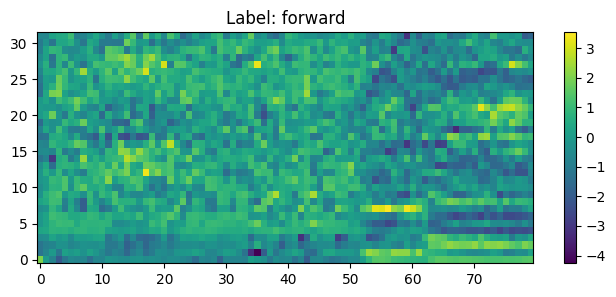

In [27]:
# Check one MFCC
for x, y in ds_all.take(1):
    plt.figure(figsize=(8,3))
    plt.imshow(x.numpy().squeeze().T, origin='lower', aspect='auto')
    plt.colorbar()
    plt.title(f"Label: {label_names[y]}")
    plt.show()

In [28]:
from tensorflow.keras import layers, models


model = models.Sequential([
    layers.Input(shape=(FIXED_FRAMES, N_MFCC, 1)),
    layers.Conv2D(16, (3,3), padding='same', activation='relu'),
    layers.DepthwiseConv2D((3,3), padding='same', activation='relu'),
    layers.Conv2D(24, (3,3), padding='same', activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(32, activation='relu'),
    layers.Dense(len(label_names), activation='softmax'),
])
model.compile(optimizer='adamw', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 80, 32, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_2              │ (None, 80, 32, 16)     │           160 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 80, 32, 24)     │         3,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 24)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,732 (18.48 KB)

 Trainable params: 4,732 (18.48 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:

model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="model.keras",
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0
)

lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=4,
    verbose=0,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.0
)


history = model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[model_checkpoint_callback, early_stopping, lr_scheduler])

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 323ms/step - accuracy: 0.2389 - loss: 1.3879 - val_accuracy: 0.2667 - val_loss: 1.3844 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 243ms/step - accuracy: 0.2481 - loss: 1.3860 - val_accuracy: 0.3333 - val_loss: 1.3836 - learning_rate: 0.0010
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 238ms/step - accuracy: 0.2333 - loss: 1.3856 - val_accuracy: 0.2167 - val_loss: 1.3845 - learning_rate: 0.0010
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 236ms/step - accuracy: 0.2685 - loss: 1.3839 - val_accuracy: 0.3000 - val_loss: 1.3788 - learning_rate: 0.0010
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 239ms/step - accuracy: 0.2870 - loss: 1.3807 - val_accuracy: 0.2167 - val_loss: 1.3797 - learning_rate: 0.0010
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 236ms/step - accuracy: 0.2685 - loss: 1.3757 - val_accuracy: 0.2500 - val_loss: 1.3641 - learning_rate: 0.0010
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 238ms/step - accuracy: 0.3130 - loss: 1.

In [30]:
best_val_acc = max(history.history['val_accuracy'])
best_epoch = history.history['val_accuracy'].index(best_val_acc) + 1  # +1 because epochs are 1-indexed

print(f"Best validation accuracy: {best_val_acc:.4f}")
print(f"Best epoch: {best_epoch}")

Best validation accuracy: 0.8833
Best epoch: 33


In [31]:
# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("model.tflite", "wb") as f:
    f.write(tflite_model)
    
print("Model saved to model.tflite")
# !xxd -i model.tflite > model_data.cc  # Uncomment to generate C array on Linux/Mac

INFO:tensorflow:Assets written to: /tmp/tmp13_56dzy/assets


INFO:tensorflow:Assets written to: /tmp/tmp13_56dzy/assets


Saved artifact at '/tmp/tmp13_56dzy'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 80, 32, 1), dtype=tf.float32, name='keras_tensor_14')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  140156325887248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140156325881680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140159094866960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140159094872912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140159094868880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140159094877328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140159094877136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140159094877712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140159094877520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140159094881552: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model saved to 

W0000 00:00:1764697025.971603  706799 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1764697025.971615  706799 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-12-02 14:37:05.971723: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp13_56dzy
2025-12-02 14:37:05.972077: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-12-02 14:37:05.972082: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp13_56dzy
2025-12-02 14:37:05.975046: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-12-02 14:37:05.993896: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmp13_56dzy
2025-12-02 14:37:05.999920: I tensorflow/cc/saved_model/loader.cc:471] SavedModel load for tags { serve }; Status: success: OK. Took 28198 microseconds.
